In [2]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [3]:
datasets, info = tfds.load(name='beans', with_info = True, as_supervised = True, split = ['train','test','validation'])

In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='/Users/babitha/tensorflow_datasets/beans/0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo num_e

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


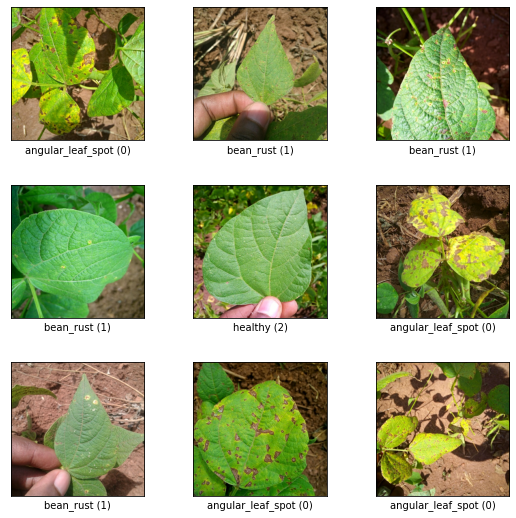

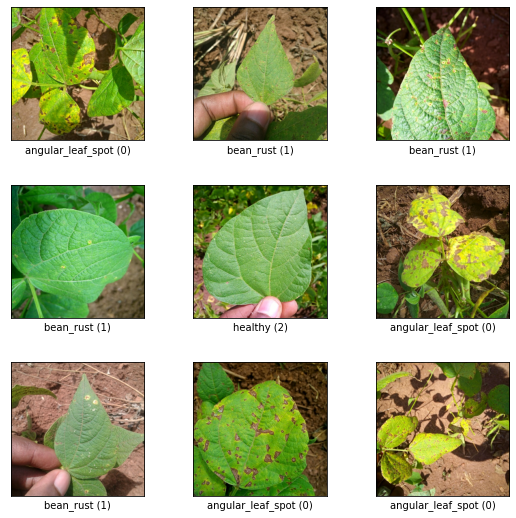

In [5]:
# how to view Sample images?
test, info_test = tfds.load(name='beans',with_info=True, split='test')
tfds.show_examples(info_test, test)

In [6]:
# Scale the image for better train convergence and resize for MobileNet
def scale(img, label):
    img = tf.cast(img, tf.float32)
    img /= 255.0
    return tf.image.resize(img,[224,224]), tf.one_hot(label, 3)

In [7]:
def get_dataset(batch_size=32):
    trn_ds_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
    tst_ds_scaled = datasets[1].map(scale).batch(batch_size)
    val_ds_scaled = datasets[2].map(scale).batch(batch_size)
    return trn_ds_scaled, tst_ds_scaled, val_ds_scaled

In [8]:
train_ds, test_ds, validate_ds = get_dataset()
train_ds.cache()
validate_ds.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [9]:
# Download the Tensorflow Mobilenet model
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [10]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [11]:
feature_extractor_layer.trainable = False

In [12]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [15]:
history = model.fit(train_ds, epochs=6, validation_data=validate_ds)

Epoch 1/6
33/33 [==============================] - 20s 467ms/step - loss: 0.8941 - acc: 0.5812 - val_loss: 0.5771 - val_acc: 0.7444
Epoch 2/6
33/33 [==============================] - 15s 453ms/step - loss: 0.5433 - acc: 0.7718 - val_loss: 0.4550 - val_acc: 0.8045
Epoch 3/6
33/33 [==============================] - 16s 462ms/step - loss: 0.4457 - acc: 0.8240 - val_loss: 0.3934 - val_acc: 0.8271
Epoch 4/6
33/33 [==============================] - 16s 467ms/step - loss: 0.3917 - acc: 0.8433 - val_loss: 0.3607 - val_acc: 0.8722
Epoch 5/6
33/33 [==============================] - 16s 475ms/step - loss: 0.3374 - acc: 0.8762 - val_loss: 0.3248 - val_acc: 0.8872
Epoch 6/6
33/33 [==============================] - 16s 482ms/step - loss: 0.3073 - acc: 0.8859 - val_loss: 0.3170 - val_acc: 0.9023


In [16]:
result = model.evaluate(test_ds)

4/4 [==============================] - 2s 427ms/step - loss: 0.2918 - acc: 0.8906


[[8.94986749e-01 1.04344346e-01 6.68819528e-04]]


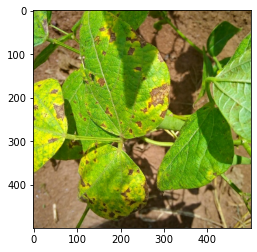

Actual Label is: angular_leaf_spot
Predicted Label is: angular_leaf_spot
[[0.00818379 0.97040534 0.02141085]]


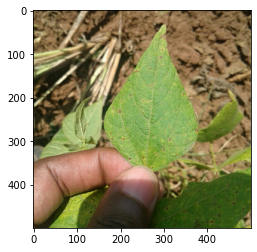

Actual Label is: bean_rust
Predicted Label is: bean_rust
[[0.44139284 0.29110014 0.26750708]]


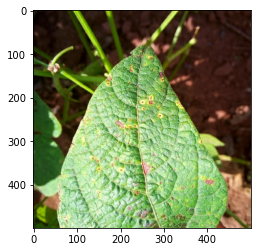

Actual Label is: bean_rust
Predicted Label is: angular_leaf_spot
[[0.00783139 0.18836378 0.80380476]]


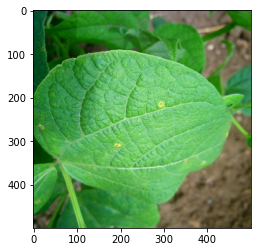

Actual Label is: bean_rust
Predicted Label is: healthy
[[0.00130546 0.00702933 0.9916652 ]]


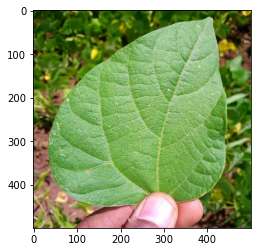

Actual Label is: healthy
Predicted Label is: healthy
[[0.6972598  0.29359773 0.00914252]]


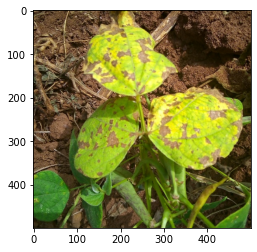

Actual Label is: angular_leaf_spot
Predicted Label is: angular_leaf_spot
[[0.01637055 0.850048   0.13358144]]


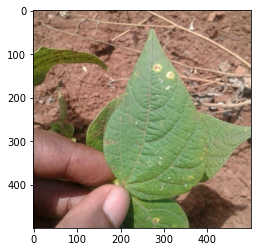

Actual Label is: bean_rust
Predicted Label is: bean_rust
[[0.969413   0.02876407 0.00182284]]


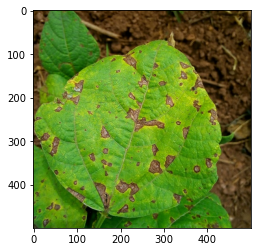

Actual Label is: angular_leaf_spot
Predicted Label is: angular_leaf_spot
[[0.86705554 0.12911062 0.00383384]]


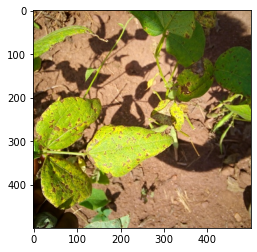

Actual Label is: angular_leaf_spot
Predicted Label is: angular_leaf_spot
[[0.12727907 0.57766944 0.29505154]]


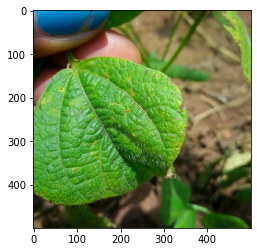

Actual Label is: bean_rust
Predicted Label is: bean_rust


In [17]:
for test_sample in datasets[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis=0)
    img = tf.keras.preprocessing.image.img_to_array(image)
    pred = model.predict(image_scaled)
    print(pred)
    plt.figure()
    plt.imshow(image)
    plt.show()
    print("Actual Label is: %s" %info.features["label"].names[label.numpy()])
    print("Predicted Label is: %s" %info.features["label"].names[np.argmax(pred)])

In [18]:
for f0, f1 in datasets[1].map(scale).batch(200):
    y = np.argmax(f1, axis=1)
    y_pred = np.argmax(model.predict(f0),axis=1)
    print(tf.math.confusion_matrix(labels = y, predictions=y_pred, num_classes=3))

tf.Tensor(
[[40  3  0]
 [ 7 33  3]
 [ 0  1 41]], shape=(3, 3), dtype=int32)


In [19]:
# Save model different ways
#1. The most Comprehensive model that saves everything (Arch, Learnable parameters, state of the model where it left off with training)
import os.path
if os.path.isfile('models/leaf-classifier.h5') is False:
    model.save('models/leaf-classifier.h5')

# The Save Function does the following:
    # Architecture - Allowing of model to recreate the model with same layers/# parameters/nodes etc..
    # Weights of model if it's already trained
    # Traiing config - Loss, Optimizer
    # State of Optmizer - Allowing to pass, save and resume training later

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
# how to load a model from saved one
from tensorflow.keras.models import load_model
if os.path.isfile('models/leaf-classifier.h5') is True:
    new_model = load_model('models/leaf-classifier.h5',custom_objects={'KerasLayer':hub.KerasLayer})
    new_model.summary()
else:
    print(f"Model doesn't exist")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
# How to check Model Weights
new_model.get_weights()
new_model.optimizer

In [32]:
from tensorflow.keras.models import model_from_json
# Save just the model architecture - just architecture - no weights, training config
json_str = model.to_json() # model.to_yml() to work with YAML file



In [35]:
model_arch = model_from_json(json_str,custom_objects={'KerasLayer':hub.KerasLayer})
model_arch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
# Save the Weights, - without archiotecture, training confogs, optimizer or loss
if os.path.isfile('models/leaf-classifier-weights.h5') is False:
    model.save_weights('models/leaf-classifier-weights.h5')

In [44]:
# Create a new model to load the weights saved above
model2 = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [45]:
model2.load_weights('models/leaf-classifier-weights.h5')

In [ ]:
model2.get_weights()

In [47]:
# Model save to pb
if os.path.isfile('models/leaf-classifier.pb') is False:
    model.save('models/leaf-classifier.pb')

INFO:tensorflow:Assets written to: models/leaf-classifier.pb/assets


INFO:tensorflow:Assets written to: models/leaf-classifier.pb/assets


In [58]:
# Testing Predictions from External Images
from PIL import Image
import numpy as np

def scale(img):
    img = tf.cast(img, tf.float32)
    img /= 255.0
    return tf.image.resize(img,[224,224])

def decode_img(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = scale(img)
  return np.expand_dims(img, axis=0)

classes=['angular_leaf_spot','bean_rust','healthy']


In [55]:
#!wget -q http://barmac.com.au/wp-content/uploads/sites/3/2016/01/Angular-Leaf-Spot-Beans1.jpg
#!wget -q http://barmac.com.au/wp-content/uploads/sites/3/2016/01/Angular-Leaf-Spot-Beans1.jpg
#!wget -q https://s3.eu-west-2.amazonaws.com/growinginteractive/diseases/bean-rust-2.jpg
!ls

Angular-Leaf-Spot-Beans1.jpg
CV-LeafClassification-TransferLearning.ipynb
bean-rust-2.jpg
models


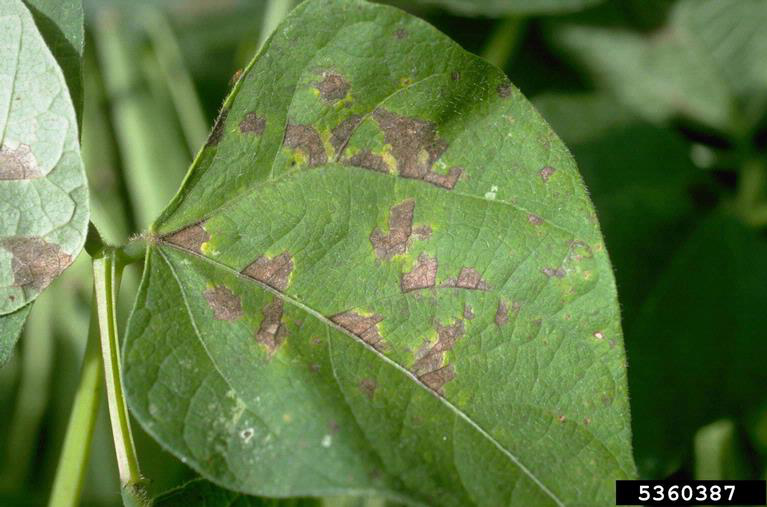

In [59]:
Image.open('Angular-Leaf-Spot-Beans1.jpg')

In [60]:
y_pred=np.argmax(model.predict(decode_img('Angular-Leaf-Spot-Beans1.jpg')),axis=1)
classes[y_pred[0]]

'angular_leaf_spot'

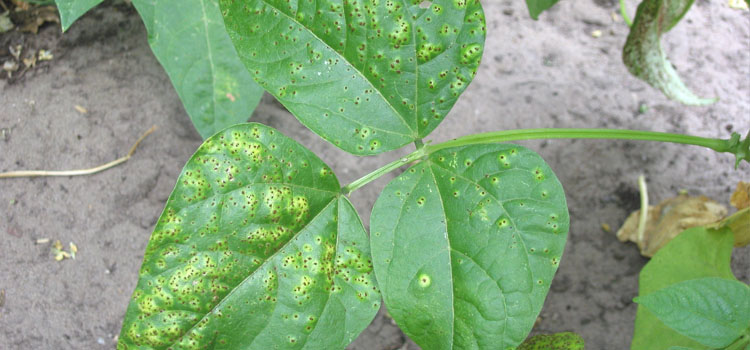

In [65]:
Image.open('bean-rust-2.jpg')


In [66]:
y_pred=np.argmax(model.predict(decode_img('bean-rust-2.jpg')),axis=1)
classes[y_pred[0]]

'bean_rust'